### Импортируем библеотики pandas, seaborn, numpy и matplotlib

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Загрузка данных

In [2]:
df_stores = pd.read_csv('C:/Users/user/Desktop/stores.csv')
df_addresses = pd.read_csv('C:/Users/user/Desktop/addresses.csv')
df_delivery_windows = pd.read_csv('C:/Users/user/Desktop/delivery_windows.csv')
df_replacements = pd.read_csv('C:/Users/user/Desktop/replacements.csv')
df_orders = pd.read_csv('C:/Users/user/Desktop/orders.csv')

###  Проверка на дубликаты и работа с пропущенными значениями

In [3]:
print(f"Дубликаты в таблице df_addresses: {df_addresses.duplicated().sum()}")
print(f"Дубликаты в таблице df_delivery_windows: {df_delivery_windows.duplicated().sum()}")
print(f"Дубликаты в таблице df_stores: {df_stores.duplicated().sum()}")


Дубликаты в таблице df_addresses: 17660
Дубликаты в таблице df_delivery_windows: 0
Дубликаты в таблице df_stores: 0


In [4]:
print("Пропущенные значения в таблице addresses:")
print(df_addresses.isnull().sum())

print("Пропущенные значения в таблице delivery_windows:")
print(df_delivery_windows.isnull().sum())

print("Пропущенные значения в таблице stores:")
print(df_stores.isnull().sum())


Пропущенные значения в таблице addresses:
lat               0
lon               0
id                0
elevator    1149771
floor         78638
dtype: int64
Пропущенные значения в таблице delivery_windows:
store_id     0
id           0
starts_at    0
ends_at      0
time_zone    0
dtype: int64
Пропущенные значения в таблице stores:
id             0
city           0
retailer_id    0
dtype: int64


### Проверка типов данных

In [5]:
print(df_addresses.dtypes)
print(df_delivery_windows.dtypes)
print(df_stores.dtypes)


lat         float64
lon         float64
id            int64
elevator     object
floor        object
dtype: object
store_id      int64
id            int64
starts_at    object
ends_at      object
time_zone    object
dtype: object
id             int64
city           int64
retailer_id    int64
dtype: object


###  Замена значений '-' на NaN в колонке floor таблицы addresses для правильной обработки данных

In [6]:
df_addresses['floor'] = df_addresses['floor'].replace('-', np.nan)

### Преобразование значений в столбце floor таблицы df_addresses в числовой формат

In [7]:
df_addresses['floor'] = pd.to_numeric(df_addresses['floor'], errors='coerce')

### Приведение столбцов к datetime и приведение числовых данных к float

In [8]:
df_delivery_windows['starts_at'] = pd.to_datetime(df_delivery_windows['starts_at'])
df_delivery_windows['ends_at'] = pd.to_datetime(df_delivery_windows['ends_at'])

df_addresses['floor'] = df_addresses['floor'].astype(float)

### Проверяем логику временных интервалов в delivery_windows

In [9]:
invalid_time_windows = df_delivery_windows[df_delivery_windows['ends_at'] < df_delivery_windows['starts_at']]
print(f"Неверные временные интервалы: {invalid_time_windows.shape[0]}")

Неверные временные интервалы: 0


## Исследование №1 "Количество заказов по временным окнам"

### Объединяем данные по ключам 'id' и 'store_id'

In [10]:
merged_data = pd.merge(df_stores, df_delivery_windows, left_on='id', right_on='store_id', how='inner', suffixes=('_store', '_order'))
print(merged_data.head(100))

    id_store  city  retailer_id  store_id  id_order           starts_at  \
0          1     1            1         1    226459 2018-08-26 14:00:00   
1          1     1            1         1    226460 2018-08-26 15:00:00   
2          1     1            1         1    226462 2018-08-26 17:00:00   
3          1     1            1         1    226458 2018-08-26 13:00:00   
4          1     1            1         1    227250 2018-08-27 15:00:00   
..       ...   ...          ...       ...       ...                 ...   
95         1     1            1         1    235744 2018-09-06 18:00:00   
96         1     1            1         1    229941 2018-08-30 07:00:00   
97         1     1            1         1    229126 2018-08-29 20:00:00   
98         1     1            1         1    232425 2018-09-02 10:00:00   
99         1     1            1         1    229951 2018-08-30 16:00:00   

               ends_at      time_zone  
0  2018-08-26 16:00:00  Europe/Moscow  
1  2018-08-26 17:00

### Создаем новый стобец с временными периодами

In [11]:
merged_data['delivery_window'] = merged_data['starts_at'].dt.hour

In [12]:
merged_data.head()

,id_store,city,retailer_id,store_id,id_order,starts_at,ends_at,time_zone,delivery_window
0,1,1,1,1,226459,2018-08-26 14:00:00,2018-08-26 16:00:00,Europe/Moscow,14
1,1,1,1,1,226460,2018-08-26 15:00:00,2018-08-26 17:00:00,Europe/Moscow,15
2,1,1,1,1,226462,2018-08-26 17:00:00,2018-08-26 19:00:00,Europe/Moscow,17
3,1,1,1,1,226458,2018-08-26 13:00:00,2018-08-26 15:00:00,Europe/Moscow,13
4,1,1,1,1,227250,2018-08-27 15:00:00,2018-08-27 17:00:00,Europe/Moscow,15


### Считаем количество заказов в разные временные окна и визуализируем результат

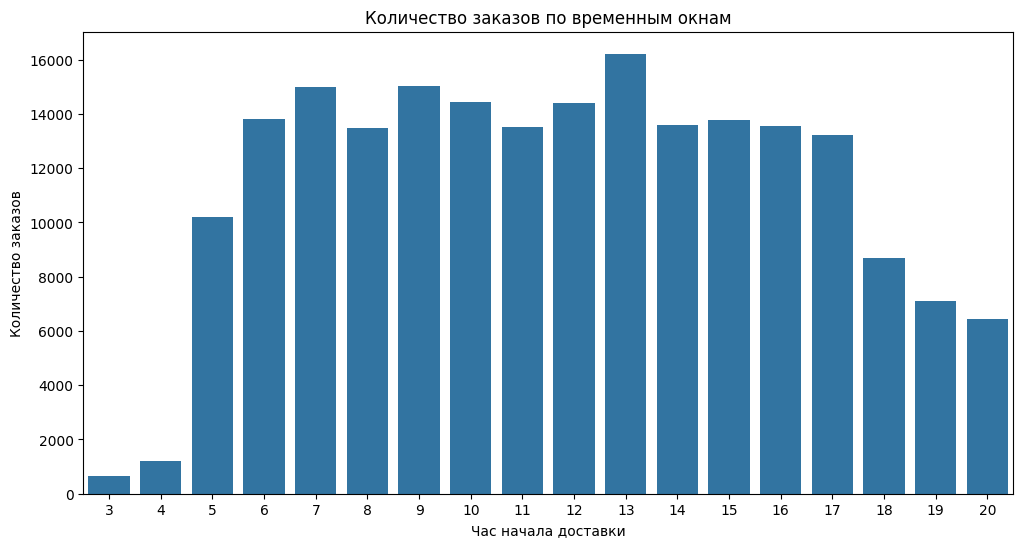

In [59]:
orders_per_time_window = merged_data.groupby('delivery_window')['id_order'].count().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='delivery_window', y='id_order', data=orders_per_time_window)
plt.title('Количество заказов по временным окнам')
plt.xlabel('Час начала доставки')
plt.ylabel('Количество заказов')
plt.show()

Выводы:
1) Наибольшая активность заказов наблюдается с 6 до 15 часов, особенно в период с 7 до 13 часов, когда количество заказов достигает пика.
2) Минимальное количество заказов регистрируется с 3 до 5 часов утра. В это время спрос на доставку крайне низкий, поэтому имеет смысл рассмотреть возможность сокращения или полного исключения временных окон для доставки в эти часы, чтобы оптимизировать ресурсы.
3) С 18 до 20 часов количество заказов постепенно снижается, но всё еще остаётся заметным. Это может быть хорошей возможностью для проведения специальных предложений, таких как "счастливые часы" - скидки или бонусы для клиентов, чтобы стимулировать больше заказов в это время.

## Исследование №2 "Количество заказов по городам"

### Считаем заказы по городам и визуалиризуем результат

In [15]:
orders_by_city = merged_data.groupby('city')['id_order'].count().reset_index()
orders_by_city.columns = ['city', 'order_count']

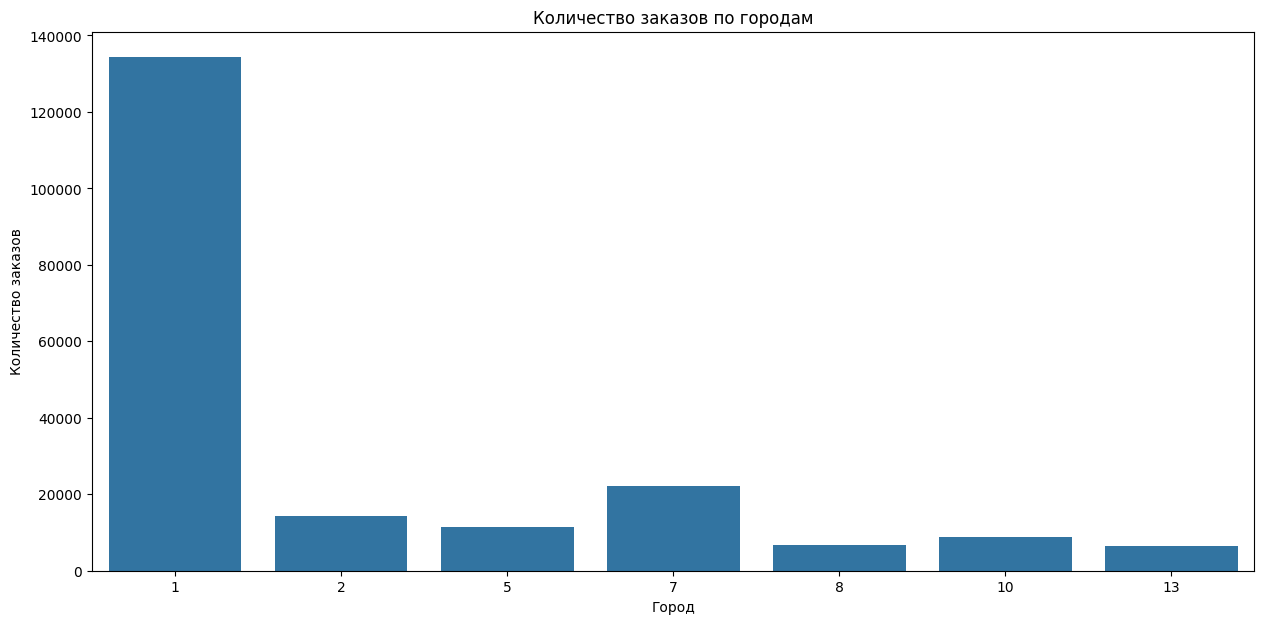

In [17]:
plt.figure(figsize=(15, 7))
sns.barplot(x='city', y='order_count', data=orders_by_city.sort_values('order_count', ascending=False))
plt.title('Количество заказов по городам')
plt.xlabel('Город')
plt.ylabel('Количество заказов')
plt.show()

Город с ID 1 доминирует по количеству заказов. Это говорит о его более высокой численности населения, популярности магазинов или активной логистике. Можно рассмотреть возможность усиления маркетинговых и логистических усилий в городах с меньшим количеством заказов, чтобы сбалансировать распределение по регионам.

## Исследование №3 "Количество заказов по ретейлерам"

In [18]:
orders_by_retailer = merged_data.groupby('retailer_id')['id_order'].count().reset_index()
orders_by_retailer.columns = ['retailer_id', 'order_count']

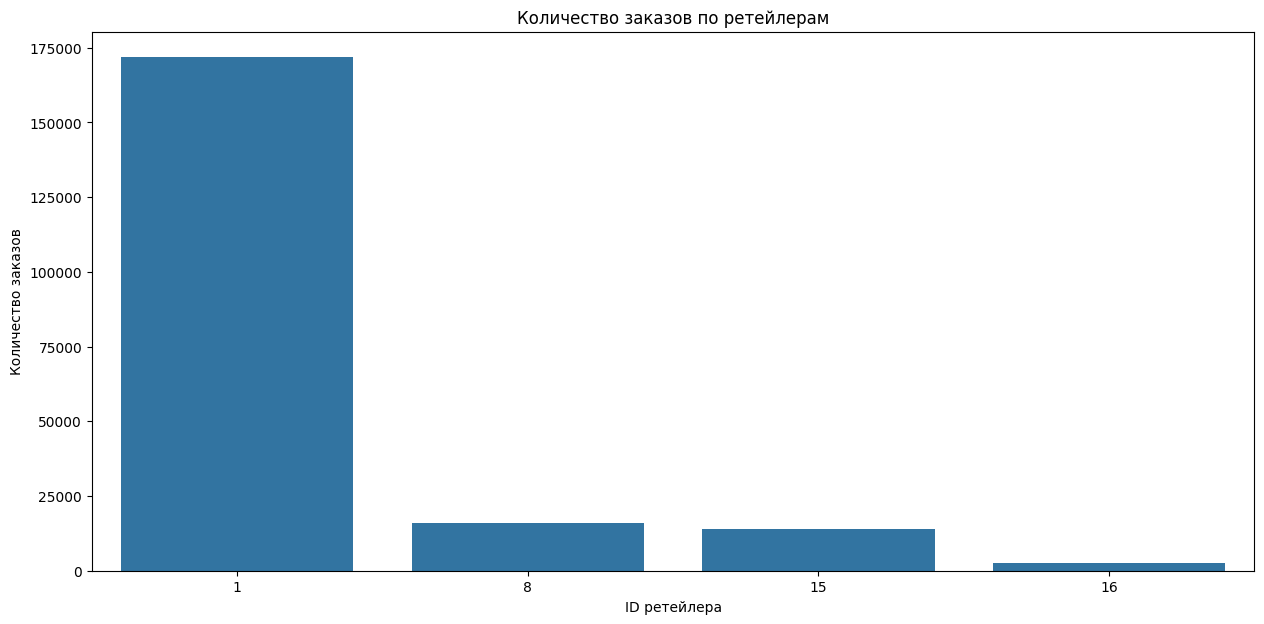

In [19]:
plt.figure(figsize=(15, 7))
sns.barplot(x='retailer_id', y='order_count', data=orders_by_retailer)
plt.title('Количество заказов по ретейлерам')
plt.xlabel('ID ретейлера')
plt.ylabel('Количество заказов')
plt.show()

На представленном графике видно, что ретейлер под ID 1 значительно доминирует по количеству заказов по сравнению с остальными. Можно рассмотреть возможность стимулирования роста заказов у остальных ретейлеров (например, через акции, маркетинг или улучшение логистики), чтобы сбалансировать нагрузку и уменьшить зависимость от одного крупного ретейлера.

## Исследование №4 "Динамика заказов по месяцам"

### Извлекаем месяц и год из даты, считаем количество заказов в месяц и визуализируем результат

In [20]:
merged_data['month_year'] = merged_data['starts_at'].dt.to_period('M')

In [21]:
merged_data

,id_store,city,retailer_id,store_id,id_order,starts_at,ends_at,time_zone,delivery_window,month_year
0,1,1,1,1,226459,2018-08-26 14:00:00,2018-08-26 16:00:00,Europe/Moscow,14,2018-08
1,1,1,1,1,226460,2018-08-26 15:00:00,2018-08-26 17:00:00,Europe/Moscow,15,2018-08
2,1,1,1,1,226462,2018-08-26 17:00:00,2018-08-26 19:00:00,Europe/Moscow,17,2018-08
3,1,1,1,1,226458,2018-08-26 13:00:00,2018-08-26 15:00:00,Europe/Moscow,13,2018-08
4,1,1,1,1,227250,2018-08-27 15:00:00,2018-08-27 17:00:00,Europe/Moscow,15,2018-08
...,...,...,...,...,...,...,...,...,...,...
204338,262,1,8,262,973304,2019-12-18 16:00:00,2019-12-18 18:00:00,Europe/Moscow,16,2019-12
204339,262,1,8,262,973305,2019-12-18 17:00:00,2019-12-18 19:00:00,Europe/Moscow,17,2019-12
204340,317,1,15,317,996053,2019-12-18 17:00:00,2019-12-18 19:00:00,Europe/Moscow,17,2019-12
204341,317,1,15,317,996052,2019-12-18 16:00:00,2019-12-18 18:00:00,Europe/Moscow,16,2019-12


In [23]:
monthly_orders = merged_data.groupby('month_year')['id_order'].count().reset_index()
monthly_orders.columns = ['month_year', 'order_count']

In [24]:
monthly_orders['month_year'] = monthly_orders['month_year'].dt.to_timestamp()

### Создаем столбец для количества заказов в предыдущем месяце

In [27]:
monthly_orders['previous_month'] = monthly_orders['order_count'].shift(1)

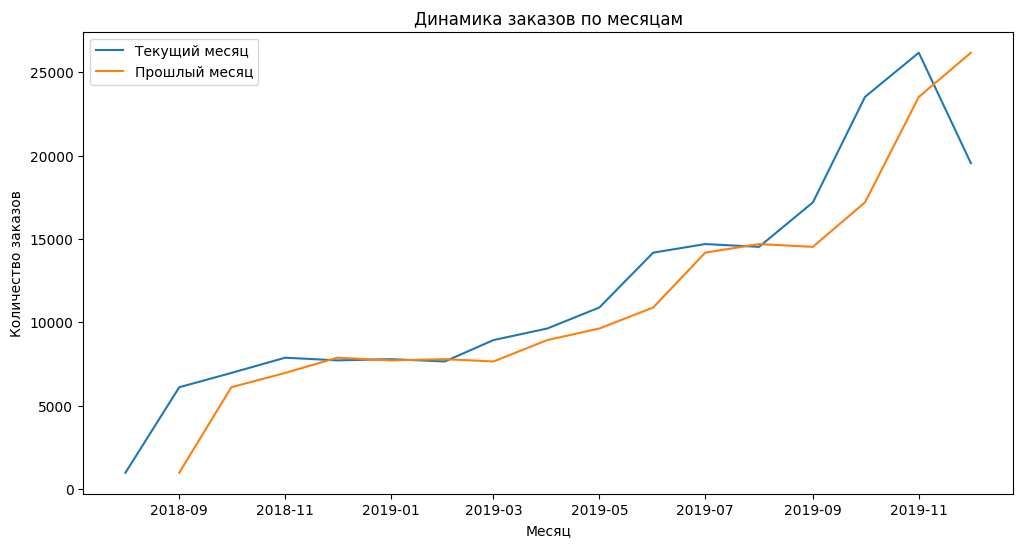

In [28]:
plt.figure(figsize=(12, 6))

# Первая линия — количество заказов по месяцам
sns.lineplot(x='month_year', y='order_count', data=monthly_orders, label='Текущий месяц')
# Вторая линия — количество заказов за прошлый месяц
sns.lineplot(x='month_year', y='previous_month', data=monthly_orders, label='Прошлый месяц')

plt.title('Динамика заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

На графике виден рост заказовс сентября 2018 года по ноябрь 2019 года. Особенно заметен рост с середины 2019 года.
С декабря 2018 года по март 2019 года, а также с июля по сентябрь 2019 года количество заказов остается примерно на одном уровне, что может говорить о сезонности (послепраздничных в первом случае и летних отпусков во втором случае).

## Исследование №5 "Среднее количества замен по ритейлерам"

In [29]:
df_replacements.head()

,order_id,item_id,state
0,480785,6466916,replaced
1,480785,6466940,replaced
2,480785,6466778,replaced
3,480785,6466825,replaced
4,480786,7261201,replaced


### Считаем количество замен по каждому заказу

In [49]:
replacements_count = df_replacements.groupby('order_id').size().reset_index(name='replacement_count')

In [50]:
replacements_count

,order_id,replacement_count
0,480375,2
1,480386,2
2,480391,1
3,480408,3
4,480428,1
...,...,...
449160,5443472,1
449161,5443574,4
449162,5443796,2
449163,5444559,2


### Соединяем replacements_count с merged_data по order_id и id_order

In [51]:
merged_replacements = replacements_count.merge(
    merged_data[['id_store', 'city', 'retailer_id', 'store_id', 'id_order']],
    left_on='order_id',
    right_on='id_order',
    how='left'
)

In [52]:
drop_merged_replacements = merged_replacements.dropna()

In [53]:
print(drop_merged_replacements.head())

    order_id  replacement_count  id_store  city  retailer_id  store_id  \
21    480635                  1      62.0   2.0          1.0      62.0   
22    480648                  2      63.0   2.0          1.0      63.0   
24    480726                  1      70.0   1.0         15.0      70.0   
36    480868                  1      84.0   5.0          1.0      84.0   
38    480872                  1      84.0   5.0          1.0      84.0   

    id_order  
21  480635.0  
22  480648.0  
24  480726.0  
36  480868.0  
38  480872.0  


### Рассчитываем среднее количество замен по ритейлерам

In [35]:
avg_replacements_per_retailer = drop_merged_replacements.groupby('retailer_id')['replacement_count'].mean().reset_index()
avg_replacements_per_retailer.columns = ['retailer_id', 'avg_replacements']
avg_replacements_per_retailer

,retailer_id,avg_replacements
0,1.0,2.451276
1,8.0,2.409009
2,15.0,2.251877
3,16.0,2.434679


### Общее среднее количество замен у ритейлеров

In [46]:
avg_replacements_per_retailer['avg_replacements'].mean().round(2)

np.float64(2.39)

### Создаем визуализацию

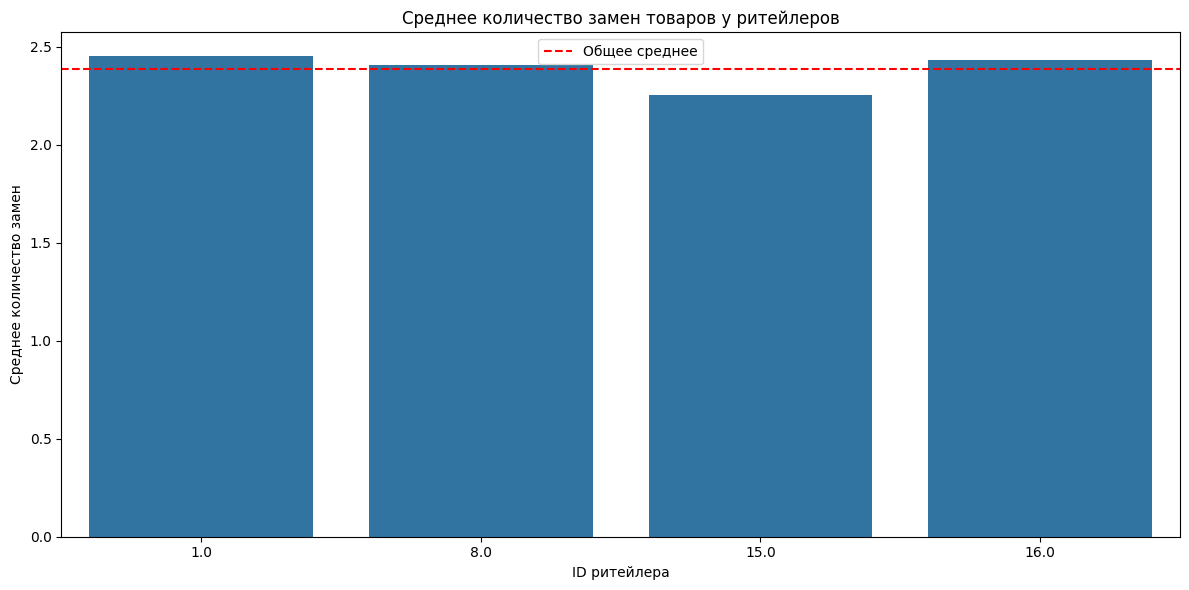

In [54]:
plt.figure(figsize=(12, 6))
sns.barplot(x='retailer_id', y='avg_replacements', data=avg_replacements_per_retailer.sort_values('avg_replacements', ascending=False))

plt.title('Среднее количество замен товаров у ритейлеров')
plt.xlabel('ID ритейлера')
plt.ylabel('Среднее количество замен')
plt.axhline(y=avg_replacements_per_retailer['avg_replacements'].mean(), color='r', linestyle='--', label='Общее среднее')
plt.legend()

plt.tight_layout()
plt.show()

Вывод по графику среднего количества замен товаров у ритейлеров:
На графике представлено среднее количество замен товаров для различных ритейлеров. Общее среднее количество замен составляет 2,38.
Ритейлеры 1, 8 и 16 показывают результаты выше среднего, Ритейлер 15 выделяется как единственный с показателем ниже всех остальных.
Частые замены в заказе могут говорить о: 
1) недостатке контроля за остатками на складе;
2) проблемах с качеством товаров;
3) проблемах с прогнозированием спроса.

## Исследование № 6 "Когортный анализ: процент клиентов, совершающих повторные покупки"

In [38]:
df_orders.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42.000,2018-08-26 02:06:55.000,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41.000,2018-08-26 05:43:20.000,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11.000,2018-08-26 06:12:13.000,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01.000,2018-08-26 06:13:59.000,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48.000,2018-08-26 07:40:58.000,870688,1,226458


### Приведение дат к типу datetime

In [39]:
df_orders['created_at'] = pd.to_datetime(df_orders['created_at'])

### Определение первой покупки каждого клиента

In [40]:
df_orders['cohort_month'] = df_orders.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

### Добавляем столбец с месяцем каждой покупки

In [41]:
df_orders['purchase_month'] = df_orders['created_at'].dt.to_period('M')

### Вычисляем смещение (количество месяцев с момента первой покупки)

In [42]:
df_orders['month_offset'] = (df_orders['purchase_month'] - df_orders['cohort_month']).apply(lambda x: x.n)

### Строим когортную таблицу, настраиваем ее и визуализируем когортный анализ с тепловой картой

In [43]:
cohort_pivot = df_orders.pivot_table(
    index='cohort_month', 
    columns='month_offset', 
    values='user_id', 
    aggfunc='nunique'
)

In [55]:
cohort_size = cohort_pivot.iloc[:, 0]

retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

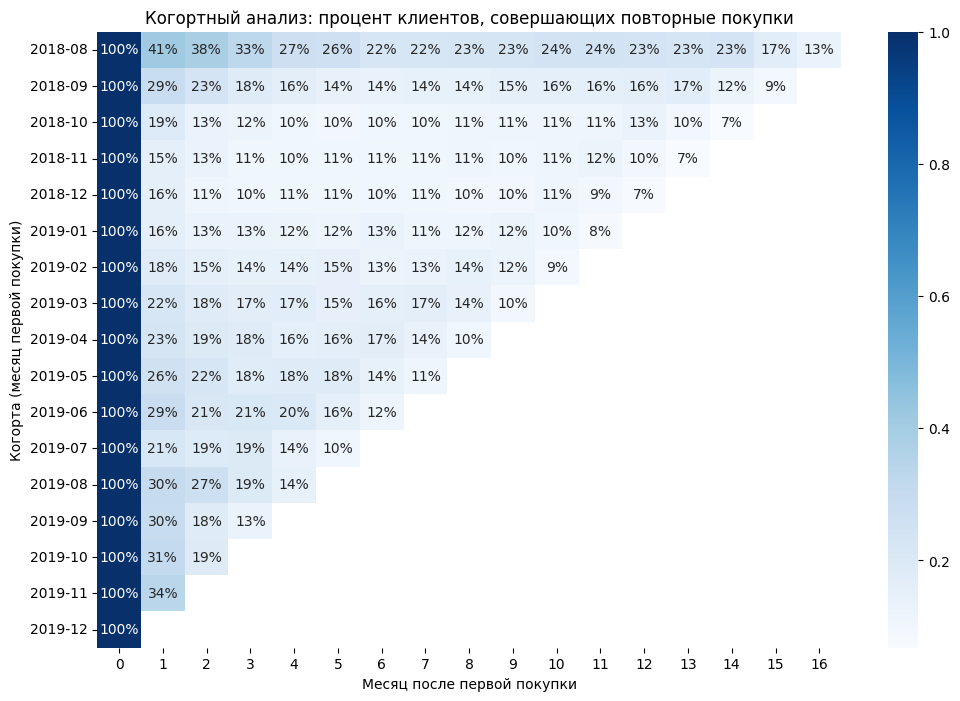

In [56]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Когортный анализ: процент клиентов, совершающих повторные покупки')
plt.ylabel('Когорта (месяц первой покупки)')
plt.xlabel('Месяц после первой покупки')
plt.show()


### Вывод:

Когортный анализ показывает, что пользователи августа 2018 года продемонстрировали наибольшую лояльность — 41% вернулись для повторной покупки через месяц, а их активность оставалась высокой (23-27%) в течение полугода. Это может быть связано с удачными акциями или сезонными факторами.

Когорта сентября 2018 года показала более быстрое снижение активности — к шестому месяцу только 16-17% клиентов продолжали покупки. Ноябрь 2019 года был наименее успешным, с удержанием всего 11% к пятому месяцу, что может говорить о неудачных маркетинговых кампаниях или сезонных изменениях.

В целом, активность клиентов стабильно снижается с течением времени, но начальные различия могут быть связаны с внешними факторами и изменениями в предложениях ритейлеров.